### Imports and Set up


In [39]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Constants
SAVE = False
SEED = 2203322

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Set up paths
base_dir = '../../dataset_26'
data_dir = './data'
train_dir = './data/train'
validation_dir = './data/validation'

# Create train and validation directories
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

### Data Cleaning/Augmentation and Splitting

Manual splitting and moving to folder

In [46]:
# Iterate through each class folder and split data
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    if os.path.isdir(folder_path):
        # Create class directories in train and validation folders
        train_class_dir = os.path.join(train_dir, folder)
        validation_class_dir = os.path.join(validation_dir, folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(validation_class_dir, exist_ok=True)

        # Split data into train and validation sets
        images = os.listdir(folder_path)
        labels = [folder] * len(images)
        train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=SEED)

        # Copy images to train and validation folders
        for image in train_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(train_class_dir, image))
        for image in validation_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(validation_class_dir, image))

classes = os.listdir(train_dir)
print(classes)

# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=lambda img: tf.image.resize(img, (224, 224)),
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

['glioma', 'meningioma', 'notumor', 'pituitary']
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


In [ ]:
# Iterate through each class folder and split data
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    if os.path.isdir(folder_path):
        # Create class directories in train and validation folders
        train_class_dir = os.path.join(train_dir, folder)
        validation_class_dir = os.path.join(validation_dir, folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(validation_class_dir, exist_ok=True)

        # Split data into train and validation sets
        images = os.listdir(folder_path)
        labels = [folder] * len(images)
        train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=SEED)

        # Copy images to train and validation folders
        for image in train_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(train_class_dir, image))
        for image in validation_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(validation_class_dir, image))

classes = os.listdir(train_dir)
print(classes)

# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.resize(img, (224, 224)),
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Auto splitting and moving to folder

In [36]:
# # tf.random.set_seed(2203322)

# # Create ImageDataGenerator for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=180,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     # shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2,  # Use 20% of data for validation
#     preprocessing_function=lambda img: tf.image.resize(img, (224, 224))
# )

# # Training data generator
# train_generator = train_datagen.flow_from_directory(
#     base_dir,
#     target_size=(224, 224),
#     batch_size=8,
#     seed=42,
#     class_mode='categorical',
#     subset='training'
# )

# # Validation data generator
# validation_generator = train_datagen.flow_from_directory(
#     base_dir,
#     target_size=(224, 224),
#     batch_size=16,
#     seed=42,
#     class_mode='categorical',
#     subset='validation'
# )

Found 384 images belonging to 4 classes.


Found 96 images belonging to 4 classes.


### Load VGG-16 Model and Set-up
Load VGG-16 model and set up for extracting features

In [43]:
# Load the VGG16 model without the top layers
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model as we have small dataset
for layer in vgg16_base.layers:
    layer.trainable = False

### Feature Extraction and Classification Training

1. 

In [44]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4197 - loss: 1.4034 - val_accuracy: 0.4062 - val_loss: 1.2810
Epoch 2/10


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

2. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 702ms/step - accuracy: 0.3896 - loss: 1.6487 - val_accuracy: 0.4167 - val_loss: 1.3418
Epoch 2/10


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3793 - loss: 1.5672 - val_accuracy: 0.2969 - val_loss: 1.4270
Epoch 2/10
 1/19 ━━━━━━━━━━━━━━━━━━━━ 15s 839ms/step - accuracy: 0.6250 - loss: 1.0676

c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6250 - loss: 1.0676 - val_accuracy: 0.2500 - val_loss: 1.4593
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6003 - loss: 0.9948 - val_accuracy: 0.3750 - val_loss: 1.3052
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7500 - loss: 0.5800 - val_accuracy: 0.0833 - val_loss: 1.5333
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6514 - loss: 0.9487 - val_accuracy: 0.3594 - val_loss: 1.2853
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6250 - loss: 1.0013 - val_accuracy: 0.3333 - val_loss: 1.5648
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6551 - loss: 0.8664 - val_accuracy: 0.4531 - val_loss: 1.2047
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8125 - loss: 0.4052 - val_accuracy: 0.5000 - val_loss: 1.2893
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6793 - loss: 0.7980 - val_accuracy: 0.5156 - val_loss: 1.1157

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,197,326 (84.68 MB)

 Trainable params: 2,493,700 (9.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 4,987,402 (19.03 MB)

3. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3732 - loss: 1.3310 - val_accuracy: 0.4062 - val_loss: 1.3063
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4375 - loss: 1.0403 - val_accuracy: 0.4167 - val_loss: 1.0330
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5698 - loss: 1.0275 - val_accuracy: 0.4688 - val_loss: 1.1663
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7500 - loss: 0.7911 - val_accuracy: 0.5833 - val_loss: 1.1072
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6785 - loss: 0.9232 - val_accuracy: 0.5156 - val_loss: 0.9993
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6875 - loss: 0.8155 - val_accuracy: 0.5833 - val_loss: 1.3857
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6331 - loss: 0.8784 - val_accuracy: 0.4844 - val_loss: 1.0924
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6875 - loss: 0.6879 - val_accuracy: 0.6667 - val_l

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,191,182 (84.65 MB)

 Trainable params: 2,492,164 (9.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,984,330 (19.01 MB)

4. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history4 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3839 - loss: 1.4778 - val_accuracy: 0.4219 - val_loss: 1.1830
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8125 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 1.0637
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5815 - loss: 0.9728 - val_accuracy: 0.5312 - val_loss: 1.1435
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6875 - loss: 0.7145 - val_accuracy: 0.5833 - val_loss: 1.1865
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6687 - loss: 0.8337 - val_accuracy: 0.5312 - val_loss: 1.1437
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8750 - loss: 0.5175 - val_accuracy: 0.5833 - val_loss: 0.9972
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6943 - loss: 0.7497 - val_accuracy: 0.5625 - val_loss: 1.1734
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6250 - loss: 0.9807 - val_accuracy: 0.4167 - val_l

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,648,462 (204.65 MB)

 Trainable params: 12,977,924 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,955,850 (99.01 MB)

5. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history5 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3109 - loss: 2.0339 - val_accuracy: 0.2969 - val_loss: 1.4238
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3125 - loss: 1.7759 - val_accuracy: 0.3333 - val_loss: 1.3352
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2819 - loss: 1.6526 - val_accuracy: 0.5000 - val_loss: 1.1775
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4375 - loss: 1.5017 - val_accuracy: 0.1667 - val_loss: 1.4130
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4113 - loss: 1.3133 - val_accuracy: 0.3906 - val_loss: 1.2785
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3125 - loss: 1.3811 - val_accuracy: 0.4167 - val_loss: 1.1662
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4924 - loss: 1.2291 - val_accuracy: 0.4531 - val_loss: 1.1758
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6250 - loss: 1.1723 - val_accuracy: 0.3333 - val_l

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,191,182 (84.65 MB)

 Trainable params: 2,492,164 (9.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,984,330 (19.01 MB)

6. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history6 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2481 - loss: 1.9091 - val_accuracy: 0.3438 - val_loss: 1.3431
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3125 - loss: 1.7574 - val_accuracy: 0.2500 - val_loss: 1.3985
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3314 - loss: 1.6763 - val_accuracy: 0.3125 - val_loss: 1.3110
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4375 - loss: 1.0688 - val_accuracy: 0.5000 - val_loss: 1.1287
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4002 - loss: 1.3516 - val_accuracy: 0.2969 - val_loss: 1.2686
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3125 - loss: 1.5197 - val_accuracy: 0.5833 - val_loss: 1.1157
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4525 - loss: 1.2145 - val_accuracy: 0.3750 - val_loss: 1.1955
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4375 - loss: 1.1616 - val_accuracy: 0.5000 - val_l

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,648,462 (204.65 MB)

 Trainable params: 12,977,924 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,955,850 (99.01 MB)

7. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history7 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2715 - loss: 2.2637 - val_accuracy: 0.3281 - val_loss: 1.4125
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3750 - loss: 2.0636 - val_accuracy: 0.4167 - val_loss: 1.2113
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4349 - loss: 1.7660 - val_accuracy: 0.4219 - val_loss: 1.2910
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2500 - loss: 2.4417 - val_accuracy: 0.5000 - val_loss: 1.3863
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4265 - loss: 1.9181 - val_accuracy: 0.4531 - val_loss: 1.2192
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3750 - loss: 1.3153 - val_accuracy: 0.4167 - val_loss: 1.1965
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4841 - loss: 1.3341 - val_accuracy: 0.4688 - val_loss: 1.1967
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6250 - loss: 1.6832 - val_accuracy: 0.5000 - val_l

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,197,326 (84.68 MB)

 Trainable params: 2,493,700 (9.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 4,987,402 (19.03 MB)

8. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history8 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3066 - loss: 2.4523 - val_accuracy: 0.3281 - val_loss: 1.3837
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5625 - loss: 1.3329 - val_accuracy: 0.1667 - val_loss: 1.4591
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4733 - loss: 1.6032 - val_accuracy: 0.5312 - val_loss: 1.1828
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4375 - loss: 1.3107 - val_accuracy: 0.4167 - val_loss: 1.4713
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5280 - loss: 1.2678 - val_accuracy: 0.5312 - val_loss: 1.0363
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7500 - loss: 1.0552 - val_accuracy: 0.8333 - val_loss: 0.7339
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6102 - loss: 1.1969 - val_accuracy: 0.5156 - val_loss: 1.0947
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5625 - loss: 1.5788 - val_accuracy: 0.4167 - val_l

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,654,606 (204.68 MB)

 Trainable params: 12,979,460 (49.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 25,958,922 (99.03 MB)

9. 

In [ ]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history9 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

model.summary()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2715 - loss: 2.2034 - val_accuracy: 0.2500 - val_loss: 1.4894
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2500 - loss: 1.8616 - val_accuracy: 0.4167 - val_loss: 1.3730
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4309 - loss: 1.5389 - val_accuracy: 0.4219 - val_loss: 1.3124
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4375 - loss: 1.5320 - val_accuracy: 0.5000 - val_loss: 1.2781
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4631 - loss: 1.4813 - val_accuracy: 0.5156 - val_loss: 1.2851
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5000 - loss: 1.4333 - val_accuracy: 0.2500 - val_loss: 1.5349
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4379 - loss: 1.3751 - val_accuracy: 0.4531 - val_loss: 1.2639
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3125 - loss: 1.6631 - val_accuracy: 0.3333 - val_l

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,281,774 (69.74 MB)

 Trainable params: 1,188,836 (4.54 MB)

 Non-trainable params: 14,715,264 (56.13 MB)

 Optimizer params: 2,377,674 (9.07 MB)

### Evaluation

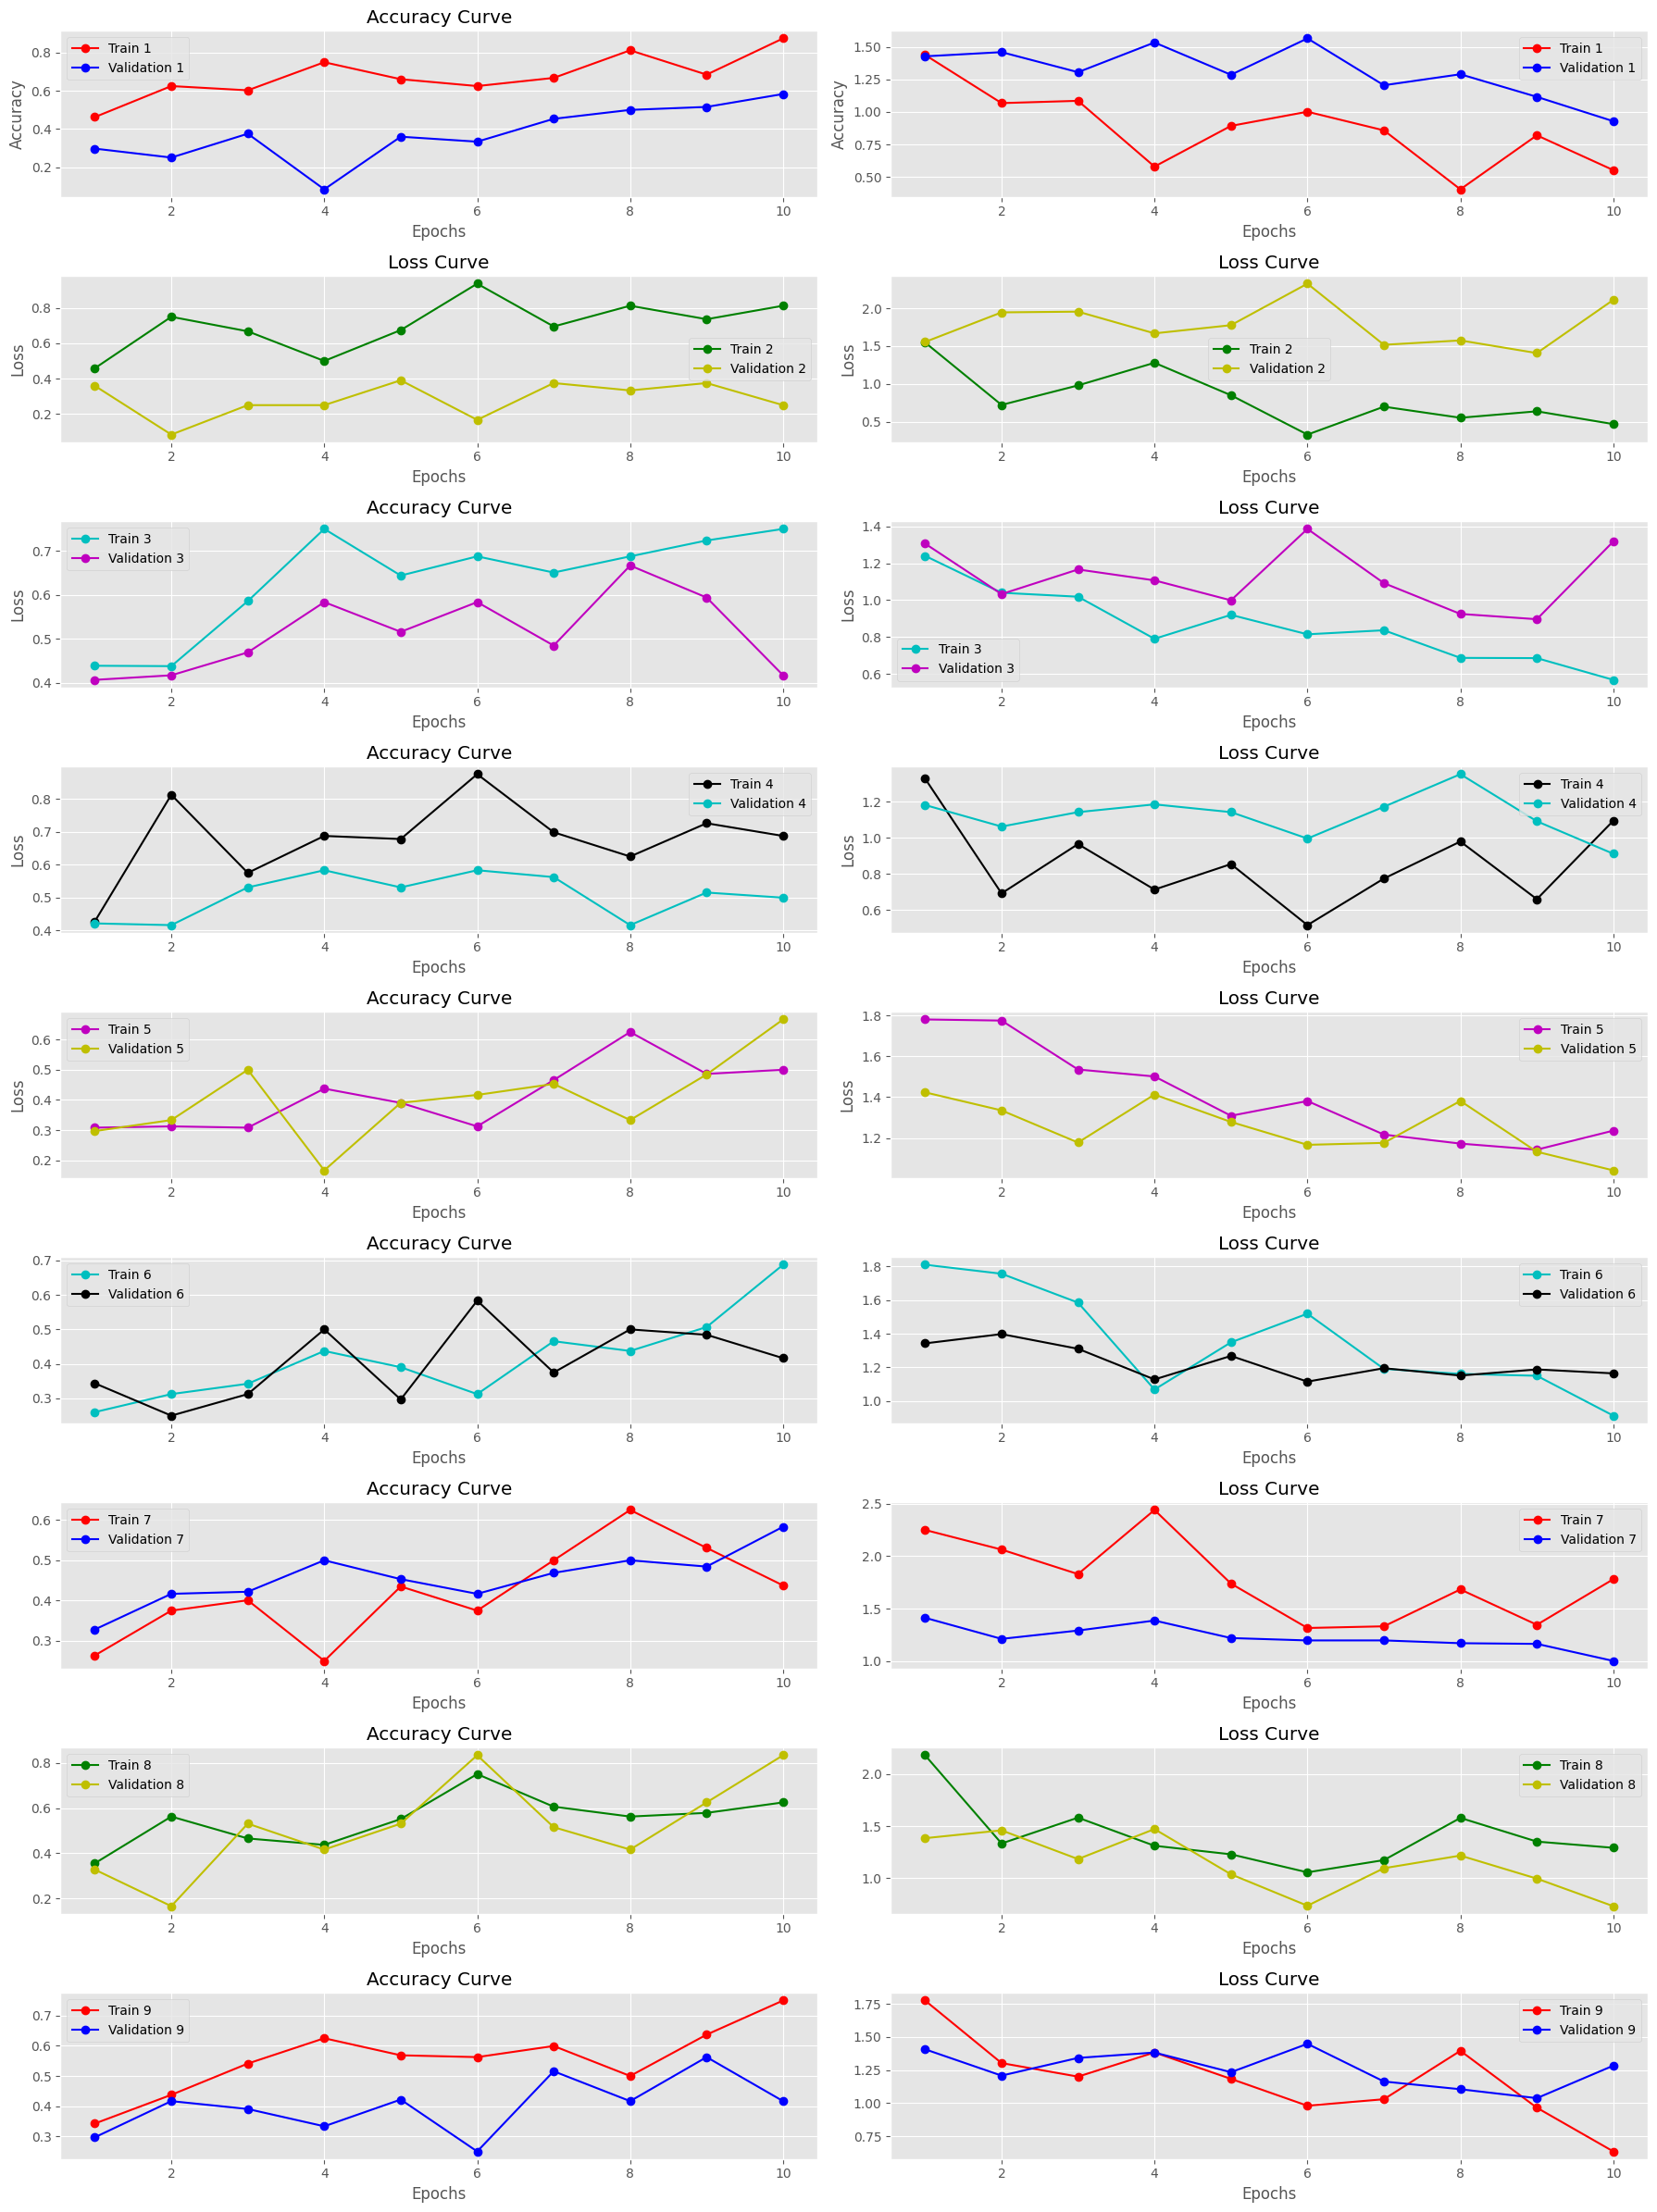

In [ ]:
# # Evaluate the model
# train_loss, train_accuracy = model.evaluate(train_generator)
# validation_loss, validation_accuracy = model.evaluate(validation_generator)
# print(f'Training loss: {train_loss}')
# print(f'Training accuracy: {train_accuracy}')
# print(f'Validation loss: {validation_loss}')
# print(f'Validation accuracy: {validation_accuracy}')

# plt.style.use('ggplot')
# figure = plt.figure(figsize=(18, 6))
# epochs = range(1, 11)

# plt.subplot(121)
# plt.plot(epochs, history.history['accuracy'], 'ro-')
# plt.plot(epochs, history.history['val_accuracy'], 'bo-')
# plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

# plt.subplot(122)
# plt.plot(epochs, history.history['loss'], 'ro-')
# plt.plot(epochs, history.history['val_loss'], 'bo-')
# plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

# figure.legend(['Train', 'Validation'])

#

# def plot_hist(hist):
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.title("model accuracy")
#     plt.ylabel("accuracy")
#     plt.xlabel("epoch")
#     plt.legend(["train", "validation"], loc="upper left")
#     plt.show()


# plot_hist(history)

plt.style.use('ggplot')
figure, axes = plt.subplots(9, 2, figsize=(18, 24))
epochs = range(1, 11)

# Plotting Accuracy
axes[0, 0].plot(epochs, history.history['accuracy'], 'ro-', label='Train 1')
axes[0, 0].plot(epochs, history.history['val_accuracy'], 'bo-', label='Validation 1')
axes[0, 0].set_xlabel('Epochs'), axes[0, 0].set_ylabel('Accuracy'), axes[0, 0].set_title('Accuracy Curve')
axes[0, 0].legend()

# Assuming history2, history3, ..., history8 are defined similarly
# You can extend this for other histories as needed
if 'history2' in locals():
    axes[1, 0].plot(epochs, history2.history['accuracy'], 'go-', label='Train 2')
    axes[1, 0].plot(epochs, history2.history['val_accuracy'], 'yo-', label='Validation 2')
    axes[1, 0].set_xlabel('Epochs'), axes[0, 1].set_ylabel('Accuracy'), axes[1, 0].set_title('Accuracy Curve')
    axes[1, 0].legend()

if 'history3' in locals():
    axes[2, 0].plot(epochs, history3.history['accuracy'], 'co-', label='Train 3')
    axes[2, 0].plot(epochs, history3.history['val_accuracy'], 'mo-', label='Validation 3')
    axes[2, 0].set_xlabel('Epochs'), axes[1, 1].set_ylabel('Accuracy'), axes[2, 0].set_title('Accuracy Curve')
    axes[2, 0].legend()

if 'history4' in locals():
    axes[3, 0].plot(epochs, history4.history['accuracy'], 'ko-', label='Train 4')
    axes[3, 0].plot(epochs, history4.history['val_accuracy'], 'co-', label='Validation 4')
    axes[3, 0].set_xlabel('Epochs'), axes[2, 0].set_ylabel('Accuracy'), axes[3, 0].set_title('Accuracy Curve')
    axes[3, 0].legend()

if 'history5' in locals():
    axes[4, 0].plot(epochs, history5.history['accuracy'], 'mo-', label='Train 5')
    axes[4, 0].plot(epochs, history5.history['val_accuracy'], 'yo-', label='Validation 5')
    axes[4, 0].set_xlabel('Epochs'), axes[2, 1].set_ylabel('Accuracy'), axes[4, 0].set_title('Accuracy Curve')
    axes[4, 0].legend()

if 'history6' in locals():
    axes[5, 0].plot(epochs, history6.history['accuracy'], 'co-', label='Train 6')
    axes[5, 0].plot(epochs, history6.history['val_accuracy'], 'ko-', label='Validation 6')
    axes[5, 0].set_xlabel('Epochs'), axes[3, 0].set_ylabel('Accuracy'), axes[5, 0].set_title('Accuracy Curve')
    axes[5, 0].legend()

if 'history7' in locals():
    axes[6, 0].plot(epochs, history7.history['accuracy'], 'ro-', label='Train 7')
    axes[6, 0].plot(epochs, history7.history['val_accuracy'], 'bo-', label='Validation 7')
    axes[6, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[6, 0].set_title('Accuracy Curve')
    axes[6, 0].legend()

if 'history8' in locals():
    axes[7, 0].plot(epochs, history8.history['accuracy'], 'go-', label='Train 8')
    axes[7, 0].plot(epochs, history8.history['val_accuracy'], 'yo-', label='Validation 8')
    axes[7, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[7, 0].set_title('Accuracy Curve')
    axes[7, 0].legend()

if 'history9' in locals():
    axes[8, 0].plot(epochs, history9.history['accuracy'], 'ro-', label='Train 9')
    axes[8, 0].plot(epochs, history9.history['val_accuracy'], 'bo-', label='Validation 9')
    axes[8, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[8, 0].set_title('Accuracy Curve')
    axes[8, 0].legend()    

# Plotting Loss
axes[0, 1].plot(epochs, history.history['loss'], 'ro-', label='Train 1')
axes[0, 1].plot(epochs, history.history['val_loss'], 'bo-', label='Validation 1')
axes[0, 1].set_xlabel('Epochs'), axes[1, 0].set_ylabel('Loss'), axes[1, 0].set_title('Loss Curve')
axes[0, 1].legend()

# Assuming history2, history3, ..., history8 are defined similarly
if 'history2' in locals():
    axes[1, 1].plot(epochs, history2.history['loss'], 'go-', label='Train 2')
    axes[1, 1].plot(epochs, history2.history['val_loss'], 'yo-', label='Validation 2')
    axes[1, 1].set_xlabel('Epochs'), axes[1, 1].set_ylabel('Loss'), axes[1, 1].set_title('Loss Curve')
    axes[1, 1].legend()

if 'history3' in locals():
    axes[2, 1].plot(epochs, history3.history['loss'], 'co-', label='Train 3')
    axes[2, 1].plot(epochs, history3.history['val_loss'], 'mo-', label='Validation 3')
    axes[2, 1].set_xlabel('Epochs'), axes[2, 0].set_ylabel('Loss'), axes[2, 1].set_title('Loss Curve')
    axes[2, 1].legend()

if 'history4' in locals():
    axes[3, 1].plot(epochs, history4.history['loss'], 'ko-', label='Train 4')
    axes[3, 1].plot(epochs, history4.history['val_loss'], 'co-', label='Validation 4')
    axes[3, 1].set_xlabel('Epochs'), axes[2, 1].set_ylabel('Loss'), axes[3, 1].set_title('Loss Curve')
    axes[3, 1].legend()

if 'history5' in locals():
    axes[4, 1].plot(epochs, history5.history['loss'], 'mo-', label='Train 5')
    axes[4, 1].plot(epochs, history5.history['val_loss'], 'yo-', label='Validation 5')
    axes[4, 1].set_xlabel('Epochs'), axes[3, 0].set_ylabel('Loss'), axes[4, 1].set_title('Loss Curve')
    axes[4, 1].legend()

if 'history6' in locals():
    axes[5, 1].plot(epochs, history6.history['loss'], 'co-', label='Train 6')
    axes[5, 1].plot(epochs, history6.history['val_loss'], 'ko-', label='Validation 6')
    axes[5, 1].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Loss'), axes[5, 1].set_title('Loss Curve')
    axes[5, 1].legend()

if 'history7' in locals():
    axes[6, 1].plot(epochs, history7.history['loss'], 'ro-', label='Train 7')
    axes[6, 1].plot(epochs, history7.history['val_loss'], 'bo-', label='Validation 7')
    axes[6, 1].set_xlabel('Epochs'), axes[4, 0].set_ylabel('Loss'), axes[6, 1].set_title('Loss Curve')
    axes[6, 1].legend()

if 'history8' in locals():
    axes[7, 1].plot(epochs, history8.history['loss'], 'go-', label='Train 8')
    axes[7, 1].plot(epochs, history8.history['val_loss'], 'yo-', label='Validation 8')
    axes[7, 1].set_xlabel('Epochs'), axes[4, 1].set_ylabel('Loss'), axes[7, 1].set_title('Loss Curve')
    axes[7, 1].legend()

if 'history9' in locals():
    axes[8, 1].plot(epochs, history9.history['loss'], 'ro-', label='Train 9')
    axes[8, 1].plot(epochs, history9.history['val_loss'], 'bo-', label='Validation 9')
    axes[8, 1].set_xlabel('Epochs'), axes[4, 1].set_ylabel('Loss'), axes[8, 1].set_title('Loss Curve')
    axes[8, 1].legend()

# Adjust layout and show the plot
figure.tight_layout()
plt.show()

### Save the Model

In [ ]:
# Save the model
model.save('vgg16_brain_tumor_classifier.keras')

### Test Predictions idk

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a new image
img_path = 'path_to_new_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)
print(f'Predicted class: {predicted_class}')